Num GPUs Available:  0
TensorFlow is running on CPU. Consider installing TensorFlow with GPU support for faster training.

--- Generating Simulated Ground Truth Labels ---
32768/32768 ━━━━━━━━━━━━━━━━━━━━ 47s 1ms/step
Simulated Anomaly Threshold: 0.0034
Number of Simulated Anomalies: 104858
Percentage of Simulated Anomalies: 10.00%

--- Starting 10-Fold Cross-Validation ---

--- Fold 1/10 ---
Training VAE on 943717 samples (unsupervised) for Fold 1.
29492/29492 ━━━━━━━━━━━━━━━━━━━━ 42s 1ms/step
3277/3277 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
Fold 1 Metrics:
  Threshold: 0.0035
  Confusion Matrix:
[[94338    34]
 [   30 10456]]
  Precision: 0.9968
  Recall:    0.9971
  F1-Score:  0.9969
  Accuracy:  0.9994

--- Fold 2/10 ---
Training VAE on 943717 samples (unsupervised) for Fold 2.
29492/29492 ━━━━━━━━━━━━━━━━━━━━ 44s 1ms/step
3277/3277 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
Fold 2 Metrics:
  Threshold: 0.0034
  Confusion Matrix:
[[94347    25]
 [   23 10463]]
  Precision: 0.9976
  Recall:    0.99

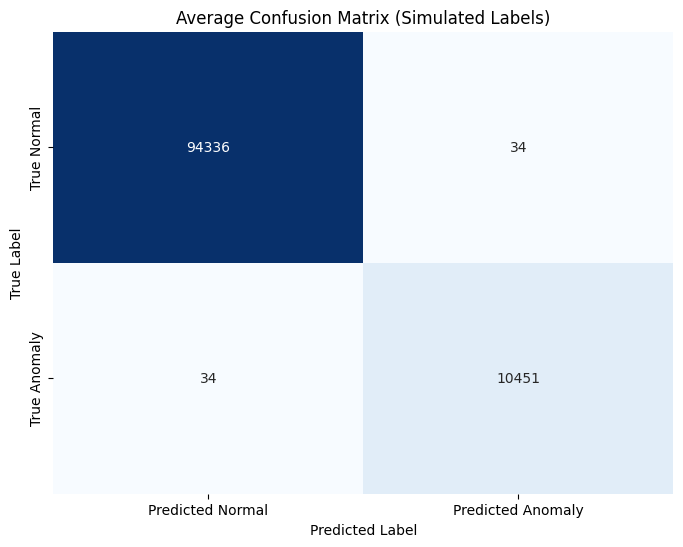


--- Overall Anomaly Detection Results (using global threshold) ---
32768/32768 ━━━━━━━━━━━━━━━━━━━━ 80s 2ms/step

Overall Anomaly Threshold: 0.0034
Overall Number of detected anomalies: 103411
Overall Percentage of detected anomalies: 9.86%


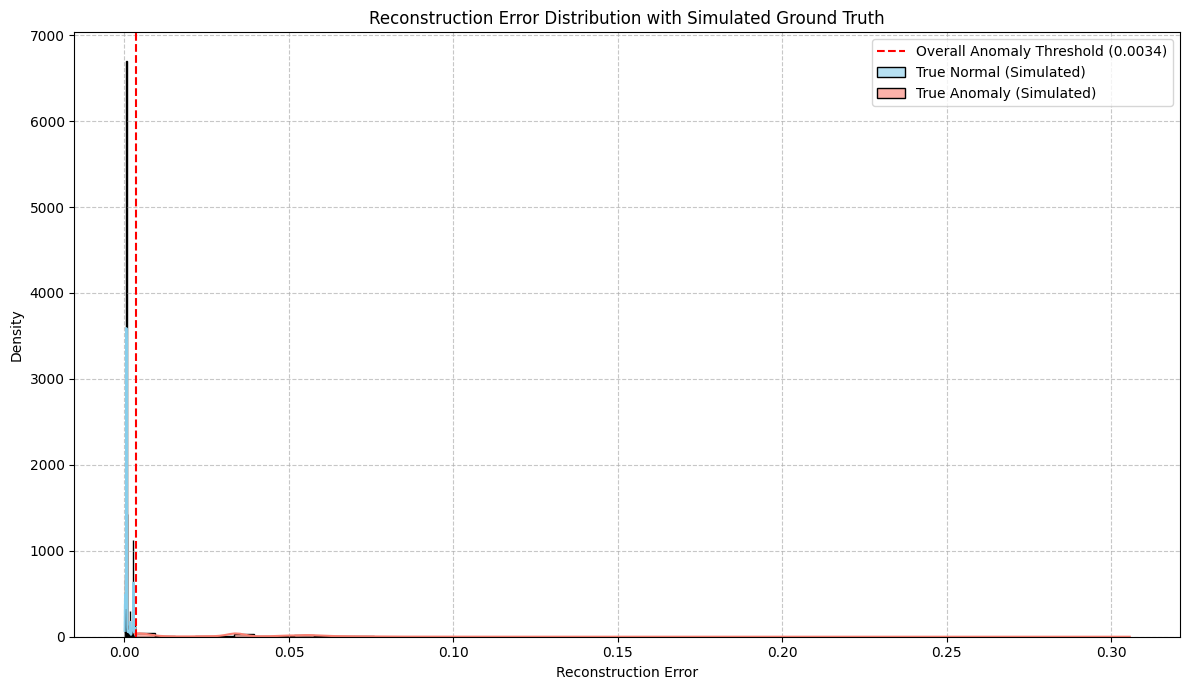


--- Overall Confusion Matrix (Simulated Labels) ---
[[943115    602]
 [  2049 102809]]


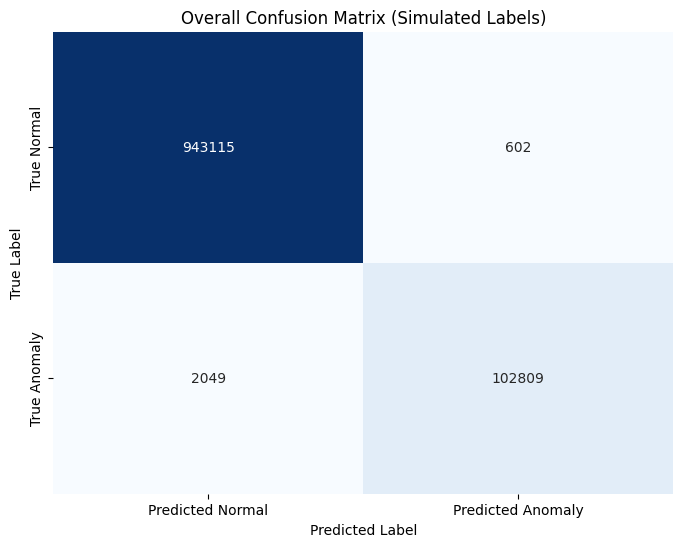

Overall Precision: 0.9942
Overall Recall:    0.9805
Overall F1-Score:  0.9873
Overall Accuracy:  0.9975


In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model, Input
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns # For better confusion matrix visualization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import ops # Import ops for Keras 3 compatible operations

# Ensure TensorFlow uses GPU if available
# This line checks for GPU devices and prints them.
# If you have a GPU and TensorFlow is installed with GPU support,
# you should see output like: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
if tf.config.list_physical_devices('GPU'):
    print("TensorFlow is using GPU.")
else:
    print("TensorFlow is running on CPU. Consider installing TensorFlow with GPU support for faster training.")


# ------------------ Load and preprocess data ------------------
# Make sure 'IoT_Intrusion.csv' is in the same directory as your script,
# or provide the full path to the file.
df = pd.read_csv("IoT_Intrusion.csv", low_memory=False)

# Define the features to be used for the VAE
features = [
    'flow_duration', 'Header_Length', 'Duration', 'Rate', 'Srate', 'Drate',
    'ack_count', 'syn_count', 'fin_count', 'urg_count', 'rst_count',
    'Tot sum', 'Min', 'Max', 'AVG', 'Std', 'Tot size', 'IAT', 'Number',
    'Magnitue', 'Radius', 'Covariance', 'Variance', 'Weight'
]

# Drop rows where any of the selected features have NaN values
df = df.dropna(subset=features)
# Fill remaining NaN values (if any, after dropping rows) with the mean of their respective columns
# numeric_only=True is used to avoid errors if non-numeric columns are present in df
df[features] = df[features].fillna(df[features].mean(numeric_only=True))

# Extract feature values and scale them to a [0, 1] range
X = df[features].values
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

input_dim = X_scaled.shape[1] # Number of input features
latent_dim = 8 # Dimension of the latent space

# ------------------ VAE model (Subclassed) ------------------
class VAE(Model):
    def __init__(self, input_dim, latent_dim, **kwargs):
        super().__init__(**kwargs)
        self.input_dim = input_dim
        self.latent_dim = latent_dim

        # Encoder layers
        self.encoder_dense_1 = layers.Dense(64, activation='relu', name='encoder_dense_1')
        self.encoder_dense_2 = layers.Dense(32, activation='relu', name='encoder_dense_2')
        self.z_mean_layer = layers.Dense(latent_dim, name='z_mean') # Mean of the latent distribution
        self.z_log_var_layer = layers.Dense(latent_dim, name='z_log_var') # Log variance of the latent distribution

        # Decoder layers
        self.decoder_dense_1 = layers.Dense(32, activation='relu', name='decoder_dense_1')
        self.decoder_dense_2 = layers.Dense(64, activation='relu', name='decoder_dense_2')
        # Output layer reconstructs the input data, sigmoid for [0,1] scaled data
        self.decoder_output = layers.Dense(input_dim, activation='sigmoid', name='decoder_output')

    # Encodes input data into mean and log-variance of the latent space
    def encode(self, inputs):
        x = self.encoder_dense_1(inputs)
        x = self.encoder_dense_2(x)
        z_mean = self.z_mean_layer(x)
        z_log_var = self.z_log_var_layer(x)
        return z_mean, z_log_var

    # Decodes a latent space vector back into the original data space
    def decode(self, z):
        d = self.decoder_dense_1(z)
        d = self.decoder_dense_2(d)
        outputs = self.decoder_output(d)
        return outputs

    # Samples from the latent distribution using the reparameterization trick
    def sampling(self, z_mean, z_log_var):
        # Generate random epsilon from a normal distribution
        epsilon = tf.random.normal(shape=tf.shape(z_mean))
        # Reparameterization trick: z = mu + sigma * epsilon
        # exp(0.5 * z_log_var) is sigma
        return z_mean + ops.exp(0.5 * z_log_var) * epsilon

    # Defines the forward pass of the VAE
    def call(self, inputs):
        z_mean, z_log_var = self.encode(inputs)
        z = self.sampling(z_mean, z_log_var)
        outputs = self.decode(z)
        return outputs

    # Custom training step to include VAE loss components (reconstruction loss + KL divergence)
    def train_step(self, data):
        # Keras models can receive data as (x, y) or x only for unsupervised learning
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            # Encode, sample, and decode
            z_mean, z_log_var = self.encode(data)
            z = self.sampling(z_mean, z_log_var)
            reconstruction = self.decode(z)

            # Calculate reconstruction loss (e.g., Mean Squared Error)
            # Scaled by input_dim to make it comparable across different input sizes
            reconstruction_loss = ops.mean(ops.square(data - reconstruction), axis=-1) * self.input_dim
            # Calculate KL divergence loss (regularization for latent space)
            # -0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
            kl_loss = -0.5 * ops.sum(1 + z_log_var - ops.square(z_mean) - ops.exp(z_log_var), axis=-1)
            # Total loss is the sum of reconstruction loss and KL loss
            total_loss = ops.mean(reconstruction_loss + kl_loss)

        # Compute gradients and apply them
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        # Return metrics for monitoring
        return {"loss": total_loss, "reconstruction_loss": ops.mean(reconstruction_loss), "kl_loss": ops.mean(kl_loss)}

# ------------------ Generate Simulated Ground Truth (y_fake_true) ------------------
# Train a VAE once on the entire dataset to establish a baseline for reconstruction errors
# to create our simulated ground truth.
print("\n--- Generating Simulated Ground Truth Labels ---")
vae_temp = VAE(input_dim, latent_dim)
vae_temp.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
# Use a smaller number of epochs for this initial training for speed, e.g., 10-20
# It doesn't need to be perfectly optimized, just enough to get a reasonable error distribution.
vae_temp.fit(X_scaled, X_scaled, epochs=15, batch_size=32, verbose=0) # Reduced epochs for speed

# Calculate reconstruction errors for the entire dataset
recon_errors_full = np.mean(np.square(X_scaled - vae_temp.predict(X_scaled)), axis=1)

# Define a percentile for anomalies to create pseudo-labels
# Lowering this percentile typically increases recall but may decrease precision.
anomaly_percentile = 90 # Changed from 97 to 90 to aim for higher recall
threshold_fake_true = np.percentile(recon_errors_full, anomaly_percentile)
y_fake_true = (recon_errors_full > threshold_fake_true).astype(int)

print(f"Simulated Anomaly Threshold: {threshold_fake_true:.4f}")
print(f"Number of Simulated Anomalies: {np.sum(y_fake_true)}")
print(f"Percentage of Simulated Anomalies: {np.sum(y_fake_true) / len(y_fake_true) * 100:.2f}%")

# ------------------ 10-Fold Cross-Validation ------------------
n_splits = 10
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

all_cm = []
all_precision = []
all_recall = []
all_f1 = []
all_accuracy = []

print(f"\n--- Starting {n_splits}-Fold Cross-Validation ---")

for fold, (train_index, test_index) in enumerate(skf.split(X_scaled, y_fake_true)):
    print(f"\n--- Fold {fold + 1}/{n_splits} ---")
    X_train_fold, X_test_fold = X_scaled[train_index], X_scaled[test_index]
    y_true_fold, y_test_fold = y_fake_true[train_index], y_fake_true[test_index] # Pseudo labels for this fold

    # Re-instantiate and compile VAE for each fold to ensure fresh weights
    vae_fold = VAE(input_dim, latent_dim)
    vae_fold.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))

    # Early stopping to prevent overfitting and reduce unnecessary training time
    # patience=10 means it will stop if loss doesn't improve for 10 consecutive epochs
    early_stopping_fold = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True, verbose=0)

    print(f"Training VAE on {X_train_fold.shape[0]} samples (unsupervised) for Fold {fold+1}.")
    vae_fold.fit(X_train_fold, X_train_fold,
                 epochs=100, # Max epochs, EarlyStopping will likely stop it sooner
                 batch_size=32,
                 shuffle=True,
                 verbose=0, # Set to 0 to suppress per-epoch output during CV for cleaner logs
                 callbacks=[early_stopping_fold])

    # Calculate reconstruction errors for training data of this fold (to determine threshold)
    recon_errors_train_fold = np.mean(np.square(X_train_fold - vae_fold.predict(X_train_fold)), axis=1)
    # Calculate reconstruction errors for test data of this fold
    recon_errors_test_fold = np.mean(np.square(X_test_fold - vae_fold.predict(X_test_fold)), axis=1)

    # Determine threshold based on the training data of the current fold
    threshold_fold = np.percentile(recon_errors_train_fold, anomaly_percentile)

    # Classify test data based on the threshold
    y_pred_fold = (recon_errors_test_fold > threshold_fold).astype(int)

    # ------------------ Confusion Matrix & Metrics for current fold ------------------
    cm_fold = confusion_matrix(y_test_fold, y_pred_fold)
    precision_fold = precision_score(y_test_fold, y_pred_fold, zero_division=0)
    recall_fold = recall_score(y_test_fold, y_pred_fold, zero_division=0)
    f1_fold = f1_score(y_test_fold, y_pred_fold, zero_division=0)
    accuracy_fold = accuracy_score(y_test_fold, y_pred_fold)

    all_cm.append(cm_fold)
    all_precision.append(precision_fold)
    all_recall.append(recall_fold)
    all_f1.append(f1_fold)
    all_accuracy.append(accuracy_fold)

    print(f"Fold {fold+1} Metrics:")
    print(f"  Threshold: {threshold_fold:.4f}")
    print(f"  Confusion Matrix:\n{cm_fold}")
    print(f"  Precision: {precision_fold:.4f}")
    print(f"  Recall:    {recall_fold:.4f}")
    print(f"  F1-Score:  {f1_fold:.4f}")
    print(f"  Accuracy:  {accuracy_fold:.4f}")

# ------------------ Aggregate and Report Cross-Validation Results ------------------
print(f"\n--- Cross-Validation Results Summary (over {n_splits} folds) ---")
print(f"Average Precision: {np.mean(all_precision):.4f} (+/- {np.std(all_precision):.4f})")
print(f"Average Recall:    {np.mean(all_recall):.4f} (+/- {np.std(all_recall):.4f})")
print(f"Average F1-Score:  {np.mean(all_f1):.4f} (+/- {np.std(all_f1):.4f})")
print(f"Average Accuracy:  {np.mean(all_accuracy):.4f} (+/- {np.std(all_accuracy):.4f})")

# Calculate average confusion matrix
# Note: Confusion matrices might have different shapes if `zero_division` was handled differently
# or if a fold had no true positives/negatives. Assuming consistent 2x2 matrices here.
avg_cm = np.mean(all_cm, axis=0).astype(int)
print("\nAverage Confusion Matrix across folds:")
print(avg_cm)

# Plotting the average Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(avg_cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted Normal', 'Predicted Anomaly'],
            yticklabels=['True Normal', 'True Anomaly'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Average Confusion Matrix (Simulated Labels)')
plt.show()

# ------------------ Re-run original analysis for plotting reconstruction errors with simulated truth ------------------
# This section is kept for visualizing the overall distribution with the globally determined threshold
print("\n--- Overall Anomaly Detection Results (using global threshold) ---")

# Train VAE on the entire dataset one last time for overall visualization
vae_final = VAE(input_dim, latent_dim)
vae_final.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
early_stopping_final = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
vae_final.fit(X_scaled, X_scaled,
              epochs=100, # Max epochs, EarlyStopping will likely stop it sooner
              batch_size=32,
              shuffle=True,
              verbose=0, # Suppress output
              callbacks=[early_stopping_final])

X_pred_final = vae_final.predict(X_scaled)
recon_errors_final = np.mean(np.square(X_scaled - X_pred_final), axis=1)

# The threshold for the overall plot comes from the initial simulated ground truth calculation
overall_threshold = threshold_fake_true
y_pred_anomaly_final = (recon_errors_final > overall_threshold).astype(int)

print(f"\nOverall Anomaly Threshold: {overall_threshold:.4f}")
print(f"Overall Number of detected anomalies: {np.sum(y_pred_anomaly_final)}")
print(f"Overall Percentage of detected anomalies: {np.sum(y_pred_anomaly_final) / len(y_pred_anomaly_final) * 100:.2f}%")

# Plotting the distribution of reconstruction errors with simulated truth overlay
plt.figure(figsize=(12, 7))
sns.histplot(recon_errors_final[y_fake_true == 0], bins=50, color='skyblue', label='True Normal (Simulated)', kde=True, stat='density', alpha=0.6)
sns.histplot(recon_errors_final[y_fake_true == 1], bins=50, color='salmon', label='True Anomaly (Simulated)', kde=True, stat='density', alpha=0.6)
plt.axvline(overall_threshold, color='red', linestyle='--', label=f'Overall Anomaly Threshold ({overall_threshold:.4f})')
plt.xlabel("Reconstruction Error")
plt.ylabel("Density")
plt.title("Reconstruction Error Distribution with Simulated Ground Truth")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Display confusion matrix for the overall results using the simulated ground truth
print("\n--- Overall Confusion Matrix (Simulated Labels) ---")
overall_cm = confusion_matrix(y_fake_true, y_pred_anomaly_final)
print(overall_cm)

plt.figure(figsize=(8, 6))
sns.heatmap(overall_cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted Normal', 'Predicted Anomaly'],
            yticklabels=['True Normal', 'True Anomaly'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Overall Confusion Matrix (Simulated Labels)')
plt.show()

print(f"Overall Precision: {precision_score(y_fake_true, y_pred_anomaly_final, zero_division=0):.4f}")
print(f"Overall Recall:    {recall_score(y_fake_true, y_pred_anomaly_final, zero_division=0):.4f}")
print(f"Overall F1-Score:  {f1_score(y_fake_true, y_pred_anomaly_final, zero_division=0):.4f}")
print(f"Overall Accuracy:  {accuracy_score(y_fake_true, y_pred_anomaly_final):.4f}")
